# KerasによるDeep Neural Network実装(CIFAR10-Grayscale)
PythonのDeep Learningライブラリ Kerasを用いてDeep Neural Networkの実装をします．

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from matplotlib import rcParams
rcParams["figure.figsize"] = [15, 5]
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['axes.titlesize'] = 18
rcParams['legend.fontsize'] = 15
rcParams['axes.grid'] = True

%matplotlib inline

Using TensorFlow backend.


## 1. データの準備

- CIFAR10データセットもKerasからimportすることができます．


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
class_label = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

- ほとんどの場合，データセットの前処理が必要です．ロードしたデータのshapeを確認し，学習に適した形式に変換します．

In [4]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)


- 今回はまずグレースケール画像での識別を行います．画像の処理はPILライブラリを使用します．
- x_train, x_testには既に数値のnumpy arrayが格納されているため，一度画像に変換(`Image,fromarray`)し，グレースケール変換(`convert('L')`)し，またnumpy arrayに戻します(`np.asarray`)．

In [5]:
from PIL import Image
import numpy as np

image_array = [Image.fromarray(np.uint8(i)) for i in x_train]
gray_image_array = [i.convert("L") for i in image_array]
X_train = np.array([np.asarray(i) for i in gray_image_array])

test_image_array = [Image.fromarray(np.uint8(i)) for i in x_test]
test_gray_image_array = [i.convert("L") for i in test_image_array]
X_test = np.array([np.asarray(i) for i in test_gray_image_array])

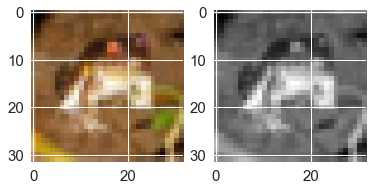

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_array[0])
plt.subplot(1,2,2)
plt.imshow(X_train[0].reshape(32, 32), cmap="gray")

- 白黒画像のnumpy arrayになっていることを確認します(次元が減っているはずです)．

In [7]:
print("x_train:",X_train.shape)
print("y_train:",y_train.shape)
print("x_test:",X_test.shape)
print("y_test:",y_test.shape)

x_train: (50000, 32, 32)
y_train: (50000, 1)
x_test: (10000, 32, 32)
y_test: (10000, 1)


- MNISTの処理と同様に，32x32の配列を1列のベクトルに変換します．

In [8]:
# 学習データを適切なshapeに変換してください

X_train = X_train.reshape(-1, 32*32)
X_test = X_test.reshape(-1, 32*32)

- 画素値の正規化を行います．通常$0-255$の値をとる画素値を，$0-1$の範囲に変換します．

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

- クラス分類タスクでは，正解ラベルをOne-hot Label形式で表現します．kerasでは，`keras.utils.to_categorical`関数で変換できます．

In [10]:
# 変換前

y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [11]:
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

In [12]:
# 変換後

Y_train[:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

- 最後に，データセットの次元を確認します．

In [13]:
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (50000, 1024)
Y_train: (50000, 10)
X_test: (10000, 1024)
Y_test: (10000, 10)


## 2. モデル構築

- SequentialモデルでDNNを構築します．`model = Sequential()`でSequentialモデルを宣言します．
- 一つのレイヤーは`Dense`レイヤーを追加することで実装できます．`Dense`では，ユニット数と活性化を指定できます．
- 一番初めの層だけは`input_shape`引数が必要です．入力の次元を指定します．

In [14]:
# モデルの構築
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(32*32,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(24, activation="relu"))
model.add(Dense(10, activation="softmax"))

- `model.summary()`関数で，構築したモデルの概要が確認できます．

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                250       
Total params: 298,642
Trainable params: 298,642
Non-trainable params: 0
_________________________________________________________________


- 構築したモデルをコンパイルします．コンパイルには，損失関数，最適化手法と評価関数が設定できます．
- 損失関数は次のものが使用できます: https://keras.io/ja/losses/
- 最適化手法は次のものが使用できます: https://keras.io/ja/optimizers/
- 評価関数は，未指定の場合はlossが採用されます．その他いくつか使用可能なものがありますが，一般にはaccuracyを用いると良いでしょう．

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

- バッチサイズ，エポック数を指定し，`model.fit`関数で学習を開始できます．
- `model.fit`をもう一度実行すると，前回の学習状態からスタートします．リセットしたい場合は，`model.reset_states()`を再実行してから`model.fit`を実行します．

In [17]:
# バッチサイズ
batch_size = 512

# エポック数
epochs = 10

In [18]:
# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s - loss: 2.1568 - acc: 0.2029 - val_loss: 2.1128 - val_acc: 0.2150
Epoch 2/10
50000/50000 [==============================] - 0s - loss: 2.0200 - acc: 0.2667 - val_loss: 1.9952 - val_acc: 0.2678
Epoch 3/10
50000/50000 [==============================] - 0s - loss: 1.9450 - acc: 0.3000 - val_loss: 1.9207 - val_acc: 0.3180
Epoch 4/10
50000/50000 [==============================] - 0s - loss: 1.8767 - acc: 0.3311 - val_loss: 1.8960 - val_acc: 0.3194
Epoch 5/10
50000/50000 [==============================] - 0s - loss: 1.8355 - acc: 0.3463 - val_loss: 1.8326 - val_acc: 0.3482
Epoch 6/10
50000/50000 [==============================] - 0s - loss: 1.8007 - acc: 0.3588 - val_loss: 1.7911 - val_acc: 0.3632
Epoch 7/10
50000/50000 [==============================] - 0s - loss: 1.7718 - acc: 0.3700 - val_loss: 1.7767 - val_acc: 0.3671
Epoch 8/10
50000/50000 [==============================] - 0s 

- `model.evaluate`関数によって現在のモデルの精度が確認できます．

In [19]:
# テストスコアの計算・表示
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 9280/10000 [==========================>...] - ETA: 0sTest loss: 1.7189999733
Test accuracy: 0.3872


## 3. モデルの評価

## 3-1. 学習過程の可視化

- エポックごとのLossとAccuracyを可視化します．
- 過学習やUnder Fittingの確認をすることができます．

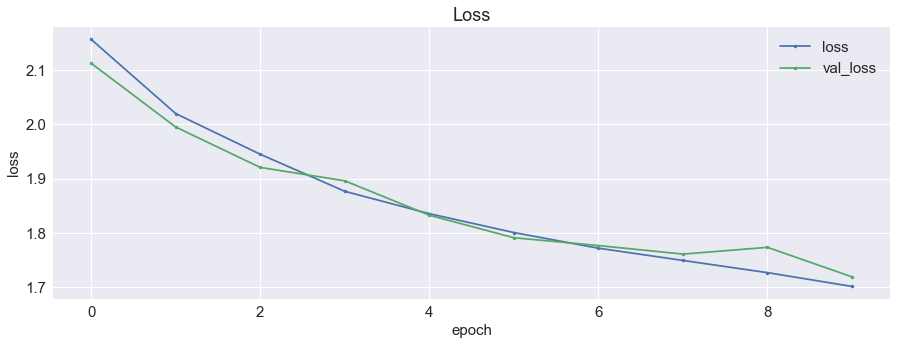

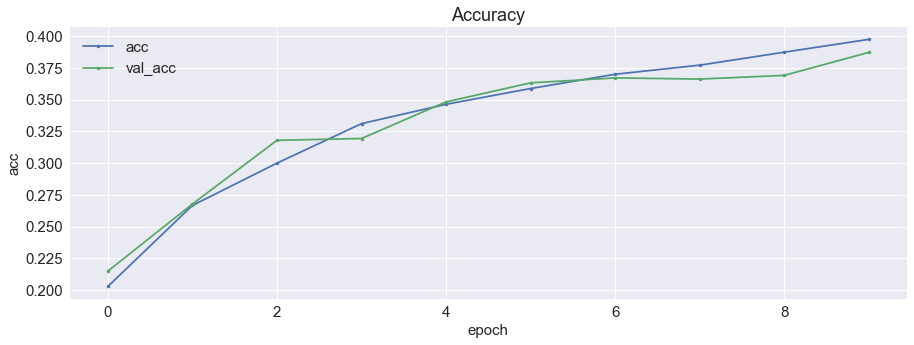

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(15,5))
plt.rcParams["font.size"] = "20"
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15,5))
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## 3-2. Confusion Matrix

- `sklearn`の`confusion_matrix`を用いると，簡単にconfusion matrixを求めることができます．`sklearn`は最も有名なPythonの機械学習ライブラリの一つです．
- `model.predict_classes`関数を用いると，現在のモデルを用いたクラス分類結果を，クラスのインデックスで得ることができます．

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

y_pred = model.predict_classes(X_test, batch_size=32, verbose=2)
y_gt = np.apply_along_axis(np.argmax,1,Y_test)

conf_matrix = confusion_matrix(y_gt,y_pred)

- 今回は，クラス分類結果数のマトリックスと，正解クラス別の予測分類結果の割合のマトリックスを表示してみます．

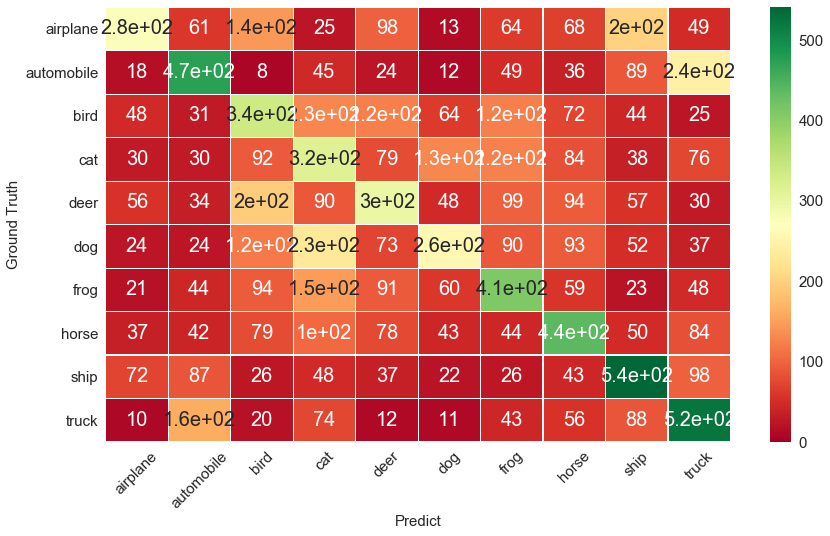

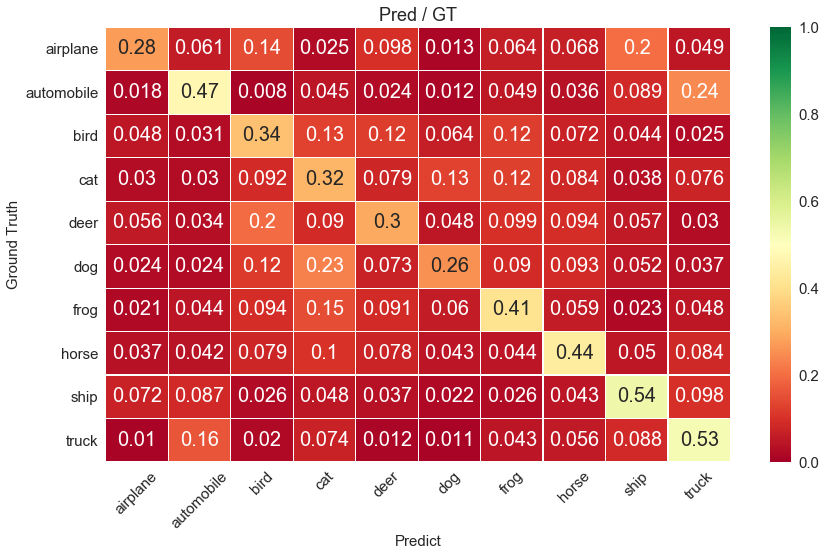

In [22]:
conf_cnt_df = pd.DataFrame(conf_matrix, columns=class_label, index=class_label)
conf_rate_df = pd.DataFrame(conf_matrix/np.sum(conf_matrix, axis=1),columns=class_label, index=class_label)

plt.figure(figsize = (14,8))
sns.heatmap(conf_cnt_df, annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.xlabel("Predict")
plt.ylabel("Ground Truth")
plt.xticks(rotation="45")
plt.show()

plt.figure(figsize = (14,8))
plt.title("Pred / GT")
sns.heatmap(conf_rate_df, annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0, vmax=1.)
plt.xlabel("Predict")
plt.ylabel("Ground Truth")
plt.xticks(rotation="45")
plt.show()

## 3-3. Recall, Precision, F-Measure

- 機械学習で一般的な評価指標であるRecall, Precision, F-Measureも求めてみます．
- Confusion Matrixを用いて，True Positive, False Positive, True Negative, False Negativeの各値を，クラスごとに求めます．

In [23]:
col=["TP","FP","TN","FN","Precision","Recall","F"]

df_evaluation = pd.DataFrame(columns=col)

for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i][i]
    fp = np.sum(conf_matrix[:,i]) - tp
    fn = np.sum(conf_matrix[i]) - tp
    tn = np.sum(conf_matrix) - tp - fp - fn
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F = 2 * recall * precision / (recall + precision)
    df_evaluation = df_evaluation.append(pd.DataFrame([[tp,fp,tn,fn,precision,recall,F]],
                                                                      columns=col),
                                                                     ignore_index=True)
df_evaluation.index = class_label

In [24]:
df_evaluation

,TP,FP,TN,FN,Precision,Recall,F
airplane,276,316,8684,724,0.466216,0.276,0.346734
automobile,474,514,8486,526,0.479757,0.474,0.476861
bird,338,779,8221,662,0.302596,0.338,0.319320
cat,316,898,8102,684,0.260297,0.316,0.285456
deer,296,615,8385,704,0.324918,0.296,0.309785
dog,256,403,8597,744,0.388467,0.256,0.308620
frog,411,664,8336,589,0.382326,0.411,0.396145
horse,439,605,8395,561,0.420498,0.439,0.429550
ship,541,642,8358,459,0.457312,0.541,0.495648
truck,525,692,8308,475,0.431389,0.525,0.473613


- 評価値の統計量を計算します，

In [25]:
df_evaluation.describe()

,Precision,Recall,F
count,10.000000,10.000000,10.000000
mean,0.391378,0.387200,0.384173
std,0.074371,0.104782,0.080149
min,0.260297,0.256000,0.285456
25%,0.339270,0.301000,0.312169
50%,0.404483,0.374500,0.371439
75%,0.450831,0.465250,0.462597
max,0.479757,0.541000,0.495648


## 3-4. モデルの保存

- `model.save`で，現在のモデルを保存できます．

In [26]:
model.save("nn_cifar.h5")

- 保存したモデルは以下のように呼び出せます．

In [27]:
# 保存したモデルを読み込む場合は実行
# model = keras.models.load_model('./mnist_data.h5')

# 4.モデルの利用

- 学習したモデルを使って，自由な画像を分類させます．
- 画像ファイルの読み込みは`PIL`ライブラリを用います．

In [28]:
from PIL import Image

#画像の読み込み
im = Image.open("./cat.jpg")

- 今回はグレースケール画像の学習を行ったため，入力画像もグレースケール変換します．`convert('L')`を用います．
- 学習には28x28画像を用いたので，入力画像も同じ解像度に変換します．`resize(32,32)`を用います．
- 画像データをnumpy配列に変換します．

In [29]:
# 画像を白黒に変換
gray_img = im.convert('L')

# 画像の解像度を変換
gray_img = gray_img.resize((32,32))

#画像をarrayに変換
im_list = np.array(gray_img, 'f')

- 学習には，黒地に白文字の画像を用いたので，入力画像によって白黒反転を行います．

In [30]:
#正規化
im_list = im_list/255.

- 画像の表示には`plt.imshow`を用います．

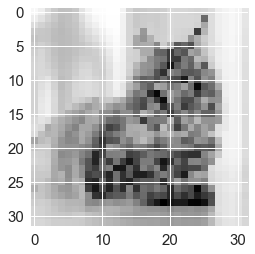

In [31]:
#入力画像の表示
plt.imshow(im_list,cmap=plt.get_cmap('gray'))

- 分類を行います．`model.predict`関数で，各クラスの分類確率を計算できます．
- 最後に，最も確率の高いクラスを分類結果として採用します．

[[ 0.02627375  0.02276642  0.10099979  0.30098298  0.01867418  0.07052386
   0.32417214  0.01627137  0.05616319  0.06317227]]


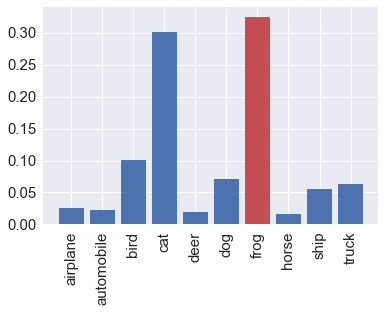



Result: frog


In [32]:
test = im_list.reshape(1, 32*32)
pred = model.predict(test)

print(pred)

colors = ['C0']*10
colors[np.argmax(pred[0])] = 'C2'

plt.figure()
plt.bar(np.arange(10), pred[0], color=colors)
plt.xticks(np.arange(10), class_label, rotation=90)
plt.show()

print('\n')
print('Result:',class_label[np.argmax(pred[0])])